# Curve fitting dati Italia

## Fonti
* Dati italiani: Protezione Civile Italia <https://github.com/pcm-dpc/COVID-19>

Codice rilasciato in licenza MIT: <https://opensource.org/licenses/MIT>

Autore: *Emanuele Zeppieri*

In [76]:
import math

import numpy as np

import scipy.stats
from scipy.signal import savgol_filter

import pandas as pd

import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe

from matplotlib.markers import CARETDOWN, CARETUP, CARETDOWNBASE, CARETUPBASE
import matplotlib.dates as mdates

import datetime as dt
from datetime import date, datetime, timedelta

from ETL_utilities import it_data_load, fix_2020_03_10, add_delta_growth_perc, add_ra, add_ra_days
from formatting_utilities import format_dates_from_numbers, numbers2dates, number2date
from file_utilities import save_in_dir

import locale
locale.setlocale(locale.LC_ALL, 'it_IT')

%load_ext autoreload
%autoreload 2

# Global constants
# PLEASE CUSTOMIZE
OUTPUT_PATH = '../output'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
from matplotlib import rcParams
def set_plt_params():
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Century Schoolbook']
    rcParams['font.size'] = 14
    rcParams['figure.dpi'] = 300

In [78]:
# Italy data load
# Caricamento dei dati dalla Protezione Civile
ds_it = it_data_load()

In [79]:
#Check
ds_it.tail(10)

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en
data,,,,,,,,,,,,,,,
2020-04-29,ITA,19210,1795,21005,83652,104657,-548,2086,71252,27682,203591,1910761,1313460.0,NaN,NaN
2020-04-30,ITA,18149,1694,19843,81708,101551,-3106,1872,75945,27967,205463,1979217,1354901.0,NaN,NaN
2020-05-01,ITA,17569,1578,19147,81796,100943,-608,1965,78249,28236,207428,2053425,1398633.0,dc-IT-0015,dc-EN-0015
2020-05-02,ITA,17357,1539,18896,81808,100704,-239,1900,79914,28710,209328,2108837,1429864.0,dc-IT-0017,dc-EN-0017
2020-05-03,ITA,17242,1501,18743,81436,100179,-525,1389,81654,28884,210717,2153772,1456911.0,NaN,NaN
2020-05-04,ITA,16823,1479,18302,81678,99980,-199,1221,82879,29079,211938,2191403,1479910.0,dc-IT-0019,dc-EN-0019
2020-05-05,ITA,16270,1427,17697,80770,98467,-1513,1075,85231,29315,213013,2246666,1512121.0,NaN,NaN
2020-05-06,ITA,15769,1333,17102,74426,91528,-6939,1444,93245,29684,214457,2310929,1549892.0,dc-IT-0021,dc-EN-0021
2020-05-07,ITA,15174,1311,16485,73139,89624,-1904,1401,96276,29958,215858,2381288,1563557.0,dc-IT-0023,dc-EN-0023


In [80]:
# Correzione dati errati 2020-03-10 nazionali
fix_2020_03_10(ds_it)

In [81]:
START_DATE = ds_it.index.min()

df_it = ds_it.copy()
df_it.index = (ds_it.index - START_DATE).days

df_it['totale_casi_DELTA'] = df_it['totale_casi'].diff()
df_it['deceduti_DELTA'] = df_it['deceduti'].diff()
df_it['tamponi_DELTA'] = df_it['tamponi'].diff()
df_it['terapia_intensiva_DELTA'] = df_it['terapia_intensiva'].diff()

tamponi_DELTA_MAX = df_it['tamponi_DELTA'].max()
df_it['totale_casi_corrected_by_tamponi_DELTA'] = df_it['totale_casi_DELTA'] * tamponi_DELTA_MAX / df_it['tamponi_DELTA']
df_it['totale_casi_corrected_by_tamponi'] = df_it['totale_casi_corrected_by_tamponi_DELTA'].cumsum()
df_it.loc[0, 'totale_casi_corrected_by_tamponi'] = df_it.loc[0, 'totale_casi'] 

# COMMENT THIS!
#df_it = df_it[:-2]

# Check
df_it.tail(20)

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,...,tamponi,casi_testati,note_it,note_en,totale_casi_DELTA,deceduti_DELTA,tamponi_DELTA,terapia_intensiva_DELTA,totale_casi_corrected_by_tamponi_DELTA,totale_casi_corrected_by_tamponi
55,ITA,25033,2635,27668,80589,108257,486,3047,47055,23660,...,1356541,935310.0,NaN,NaN,3047.0,433.0,50708.0,-98.0,4459.094739,675611.368466
56,ITA,24906,2573,27479,80758,108237,-20,2256,48877,24114,...,1398024,943151.0,dc-IT-0007,dc-EN-0007,2256.0,454.0,41483.0,-62.0,4035.707350,679647.075816
57,ITA,24134,2471,26605,81104,107709,-528,2729,51600,24648,...,1450150,971246.0,pd-IT-0013,pd-EN-0013,2729.0,534.0,52126.0,-102.0,3885.079078,683532.154894
58,ITA,23805,2384,26189,81510,107699,-10,3370,54543,25085,...,1513251,1015494.0,NaN,NaN,3370.0,437.0,63101.0,-87.0,3963.185369,687495.340263
59,ITA,22871,2267,25138,81710,106848,-851,2646,57576,25549,...,1579909,1052577.0,pd-IT-0015;pd-IT-0017,pd-EN-0015;pd-EN-0017,2646.0,464.0,66658.0,-117.0,2945.698461,690441.038724
60,ITA,22068,2173,24241,82286,106527,-321,3021,60498,25969,...,1642356,1147850.0,dc-IT-0009;dc-IT-0011,dc-EN-0009;dc-EN-0011,3021.0,420.0,62447.0,-94.0,3589.962176,694031.000900
61,ITA,21533,2102,23635,82212,105847,-680,2357,63120,26384,...,1707743,1186526.0,NaN,NaN,2357.0,415.0,65387.0,-71.0,2674.969887,696705.970787
62,ITA,21372,2009,23381,82722,106103,256,2324,64928,26644,...,1757659,1210639.0,dc-IT-0013,dc-EN-0013,2324.0,260.0,49916.0,-93.0,3454.992227,700160.963014
63,ITA,20353,1956,22309,83504,105813,-290,1739,66624,26977,...,1789662,1237317.0,NaN,NaN,1739.0,333.0,32003.0,-53.0,4032.362966,704193.325980
64,ITA,19723,1863,21586,83619,105205,-608,2091,68941,27359,...,1846934,1274871.0,NaN,NaN,2091.0,382.0,57272.0,-93.0,2709.333147,706902.659127


In [82]:
xvals_ext_CUM = np.arange(200)
xvals_ext_DELTA = np.arange(0, 200)
#yvals = df_it['totale_casi_DELTA'][1:].to_numpy()

'''
def totale_casi():
    yvals_orig = df_it['totale_casi'][:].to_numpy()
    return df_it.index[:].to_numpy(), xvals_ext_CUM, savgol_filter(yvals_orig, 13, 2) if filter else yvals_orig

def totale_positivi():
    yvals_orig = df_it['totale_positivi'][:].to_numpy()
    return df_it.index[:].to_numpy(), xvals_ext_CUM, savgol_filter(yvals_orig, 23, 2) if filter else yvals_orig

def totale_casi_DELTA(filter=True):
    yvals_orig = df_it['totale_casi_DELTA_corrected_by_tamponi'][1:].to_numpy()
    return df_it.index[1:].to_numpy(), xvals_ext_DELTA, savgol_filter(yvals_orig, 23, 2) if filter else yvals_orig

def deceduti_DELTA(filter=True):
    yvals_orig = df_it['deceduti_DELTA'][1:].to_numpy()
    return df_it.index[1:].to_numpy(), xvals_ext_DELTA, savgol_filter(yvals_orig, 27, 3) if filter else yvals_orig
'''

def DELTA_values(column, filter=True):
    yvals_orig = df_it[column][:].to_numpy()
    #return df_it.index[1:].to_numpy(), xvals_ext_DELTA, df_it[column][1:].rolling(window=17, center=True, min_periods=9).mean()
    return df_it.index[:].to_numpy(), xvals_ext_DELTA, savgol_filter(yvals_orig, 27, 4) if filter else yvals_orig

COLUMN = 'terapia_intensiva' # 'totale_casi_DELTA', 'deceduti_DELTA', 'totale_casi_DELTA_corrected_by_tamponi', 
FILTER = False

xvals, xvals_ext, yvals = DELTA_values(COLUMN, filter=FILTER)

In [83]:
from lmfit import Model
from scipy import special
import scipy.integrate as integrate

from lmfit.models import(
    GaussianModel, SkewedGaussianModel, LorentzianModel, ExponentialGaussianModel, StudentsTModel, Pearson7Model, MoffatModel,
    SplitLorentzianModel, VoigtModel, SkewedVoigtModel, LognormalModel, StepModel, RectangleModel, ExponentialModel, DonaichModel, BreitWignerModel
)

def Gompertz(x, amplitude, center, sigma):
    return amplitude * (1 - np.exp(-center*(np.exp(sigma*x)-1)))

def log_normal_PDF(x, s, loc, scale):
    return scipy.stats.lognorm.pdf(x, s, loc, scale)

def log_normal_2(x, a, mu, sigma):
    return a *(np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))

#LogNormal_CDF = Model(log_normal_CDF)
#Gompertz_CDF = Model(Gompertz)

#model = Model(log_normal_2)
model = SkewedGaussianModel()
# set initial parameter values

# SkewNormal
params = model.make_params(amplitude=172774, center=23, sigma=27, gamma=3)

# LogNormal
# params = model.make_params(amplitude=19374895, center=100, sigma=16, gamma=30)

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 75
    # variables        = 4
    chi-square         = 92.9844323
    reduced chi-square = 1.30963989
    Akaike info crit   = 24.1207978
    Bayesian info crit = 33.3907503
[[Variables]]
    amplitude:  177978.915 +/- 600.363159 (0.34%) (init = 172774)
    center:     23.3297944 +/- 0.10737531 (0.46%) (init = 23)
    sigma:      29.9283378 +/- 0.20473051 (0.68%) (init = 27)
    gamma:      3.15540027 +/- 0.04736325 (1.50%) (init = 3)
    height:     2372.44442 +/- 13.8263931 (0.58%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
    fwhm:       70.4758483 +/- 0.48210349 (0.68%) == '2.3548200*sigma'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma)     = -0.881
    C(sigma, gamma)      =  0.871
    C(center, sigma)     = -0.816
    C(amplitude, sigma)  =  0.525
    C(amplitude, gamma)  =  0.417
    C(amplitud

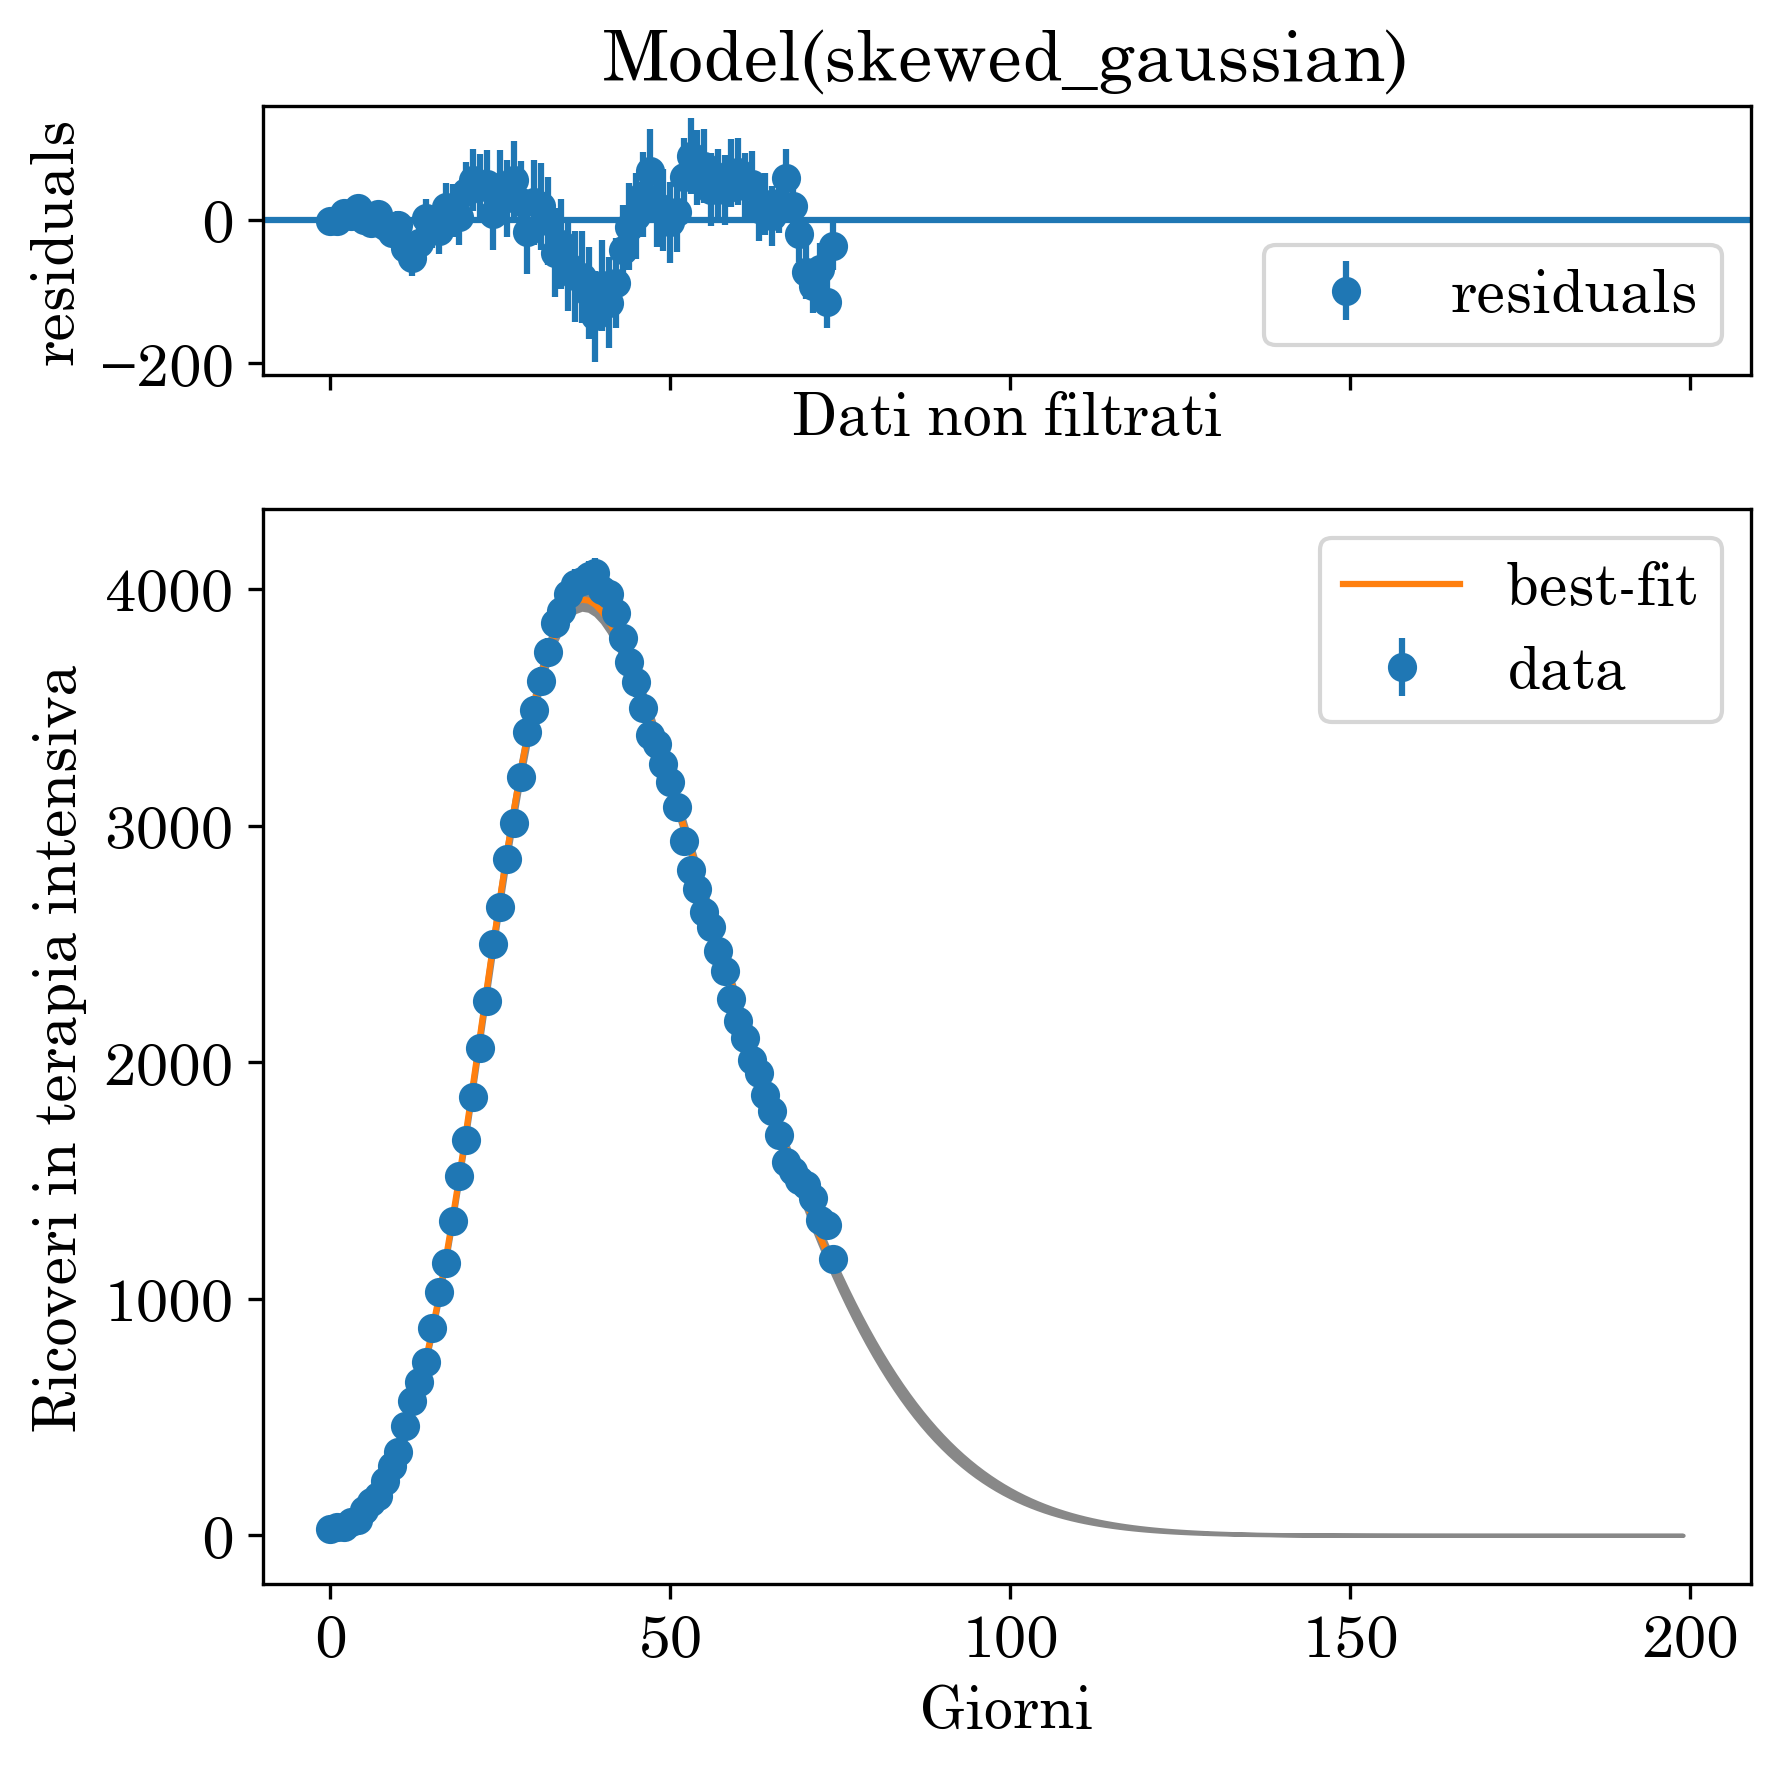

In [84]:
set_plt_params()

# adjust parameters  to best fit data.
result = model.fit(yvals, params, x=xvals, weights=np.sqrt(1.0/yvals))
#result = model.fit(yvals, params, x=xvals)
predicted_res = result.eval(x=xvals_ext)

print(result.fit_report())

#plt.plot(xvals, yvals, 'o', markersize=3, color='tab:red')
#plt.plot(xvals, result.best_fit, color='tab:blue')

result.plot(xlabel='Giorni', ylabel='Ricoveri in terapia intensiva', ax_res_kws={'xlabel': 'Dati non filtrati'})

dely_res = result.eval_uncertainty(x=xvals_ext, sigma=0.99)

#plt.plot(xvals, data)
#plt.plot(xvals_ext, predicted)

plt.fill_between(xvals_ext, predicted_res-dely_res, predicted_res+dely_res, color='#888888')

fig_fit_report = plt.gcf()

plt.show()

In [85]:
# StepModel
# To be implemented

# PeakModel
predicted_DELTA = predicted_res
#predicted_CUM   = np.insert(predicted_res, 0, df_it['deceduti'].iloc[0])
predicted_CUM   = predicted_res
predicted_CUM   = np.cumsum(predicted_CUM)

predicted_DELTA_index = xvals_ext
predicted_CUM_index   = xvals_ext_CUM

dely_DELTA = dely_res
dely_CUM = [dely_DELTA[0]]

# Cast dely_DELTA over dely_CUM
for i, v in enumerate(dely_DELTA[:-1]):
    sum = 0;
    for v_DELTA in dely_DELTA[:i+1]:
        sum += v_DELTA * v_DELTA
    dely_CUM.append(np.sqrt(sum))

In [86]:
reversed_predicted_DELTA = list(reversed(predicted_DELTA))
reversed_dely_DELTA = list(reversed(dely_DELTA))
len_predicted_DELTA = len(predicted_DELTA)

def limits(threshold):
    min_index = avg_index = max_index = 1_000

    for i, v in enumerate(reversed_predicted_DELTA):
        if v - reversed_dely_DELTA[i] > threshold:
            min_index = len_predicted_DELTA - i
            break;

    for i, v in enumerate(reversed_predicted_DELTA):
        if v > threshold:
            avg_index = len_predicted_DELTA - i
            break;

    for i, v in enumerate(reversed_predicted_DELTA):
        if v + reversed_dely_DELTA[i] >= threshold:
            max_index = len_predicted_DELTA - i
            break;
    
    return min_index, avg_index, max_index 

In [87]:
min_index, avg_index, max_index = limits(100)

print(min_index, avg_index, max_index)
#predicted_DELTA, dely_DELTA

106 107 108


In [88]:
SUBTITLE = 'Dati Italia: https://github.com/pcm-dpc/COVID-19 (dati del 10/03/2020 corretti) - Dati Cina: https://github.com/CSSEGISandData/COVID-19 \nCodice: https://github.com/emazep/COVID-19-Statistics'
SUBTITLE_NO_CHN = 'Fonte dati: https://github.com/pcm-dpc/COVID-19 (dati del 10/03/2020 corretti)\nCodice: https://github.com/emazep/COVID-19-Statistics'
SUBTITLE_NO_CHN_NO_CORR = 'Fonte dati: https://github.com/pcm-dpc/COVID-19\nCodice: https://github.com/emazep/COVID-19-Statistics'
ALPHA = 0.5
COMMON_PLT_PARAMS = {'markersize':8, 'linewidth':4}

In [89]:
def plot_cases(column):
    plt.rcParams.update(mpl.rcParamsDefault)
    set_plt_params()
    rcParams['font.size'] = 12
    #rcParams['axes.titlesize'] = 'x-large'
    
    if column == 'deceduti':
        TITLE = 'Decessi'
        BACKSHIFT = 5
    else:
        TITLE = 'Casi'
        BACKSHIFT = 0

    max_date = ds_it.index.max()

    prediction_date_str = max_date.strftime('%d/%m/%Y')

    ax = df_it.plot(
        y='totale_casi', label=TITLE+' totali osservati',
        linewidth=3, markersize=7, marker='o', figsize=(16, 9), color='red', zorder=4
    )
    ax.plot(
        predicted_CUM_index, predicted_CUM, linewidth=3, markersize=7, marker='o', color='tab:blue',
        label= TITLE+' totali previsti\n(dati filtrati)', zorder=2
    )
    ax.fill_between(predicted_CUM_index, predicted_CUM-dely_CUM, predicted_CUM+dely_CUM, color='limegreen', alpha=0.4, zorder=1)

    ax2 = ax.twinx()

    ax2.bar(predicted_DELTA_index, predicted_DELTA, label='Nuovi '+TITLE+' giornalieri previsti\n(dati filtrati)', color='tab:blue', zorder=0)
    ax2.bar(df_it.index, df_it[column], label='Nuovi '+TITLE+' giornalieri osservati', color='orange', zorder=1, alpha=0.7)
    ax2.fill_between(
        predicted_DELTA_index, predicted_DELTA-dely_DELTA, predicted_DELTA+dely_DELTA, color='limegreen', alpha=0.4, zorder=0,
        label='Intervallo di confidenza al 99%'
    )

    special_x = {
        15: 'Lockdown',
        #62: 'Prediz. min.',
        #avg_index+1: 'Data più prob.'
    }

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format_dates_from_numbers(x, p, special=special_x, rotate=True)))
    ax.tick_params(axis='x', which='both', labelsize=9, rotation=90)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.yaxis.set_major_locator(ticker.MultipleLocator(5_000))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
    ax.tick_params(axis='y', which='both', labelsize=10)
    ax.set_ylabel(TITLE+' totali', fontsize=20)

    ax2.yaxis.set_major_locator(ticker.MultipleLocator(200))
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
    ax2.tick_params(axis='y', which='both', labelsize=11)
    ax2.set_ylabel('Nuovi '+TITLE+' giornalieri', fontsize=20)

    ax.grid(which='both', alpha=ALPHA)
    #ax.tick_params(axis='y', which='both', right=True, labelright=True)

    #plt.axvline(x=48, linewidth=3.5, zorder=4, color='tab:red', label='Pasqua')
    ax.axvline(x=14, linewidth=3.5, markersize=8, marker='o', zorder=4, color='saddlebrown', ymax=0.46)
    #plt.axvline(x=61, linewidth=3.5, markersize=8, zorder=4, color='green')

    #plt.axvline(x=avg_index, linewidth=3.5, zorder=0, color='green')
    plt.axvspan(min_index-BACKSHIFT, max_index-BACKSHIFT, facecolor='limegreen', alpha=0.4, zorder=0)
    ax.text(
        0.96, 0.5, 'Previsione i.c. 99%\nnuovi casi giornalieri < 10',
        horizontalalignment='center', verticalalignment='center', rotation='vertical',
        transform=ax.transAxes, fontsize=24, fontweight='bold', color='g', zorder=10
    )

    ax.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0)
    plt.xlim(left=0, right=max_index-BACKSHIFT)
    #ax.set_xlabel('Giorni di lockdown', fontsize=20)

    ax.set_title(SUBTITLE_NO_CHN, fontsize=14)
    plt.suptitle('Previsione andamento Casi diagnosticati basato su '+TITLE+' Italia del ' + prediction_date_str, fontsize=22)

    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    sep = '\n———————————————'
    ax.legend(
        handles+list(reversed(handles2)), labels+list(reversed(labels2)),
        title='Previsione Casi Italia al ' + prediction_date_str + sep + '\nFitting: Normale asimmetrica\nsu incremento giornaliero '+TITLE+'.\nFiltro dati: Savitzky–Golay.' + sep,
        fontsize=10, bbox_to_anchor=(0.85, 0.75)
    )

    ax.set_zorder(1)
    ax.patch.set_visible(False)

    fig = plt.gcf()
    plt.show()
    
    return fig

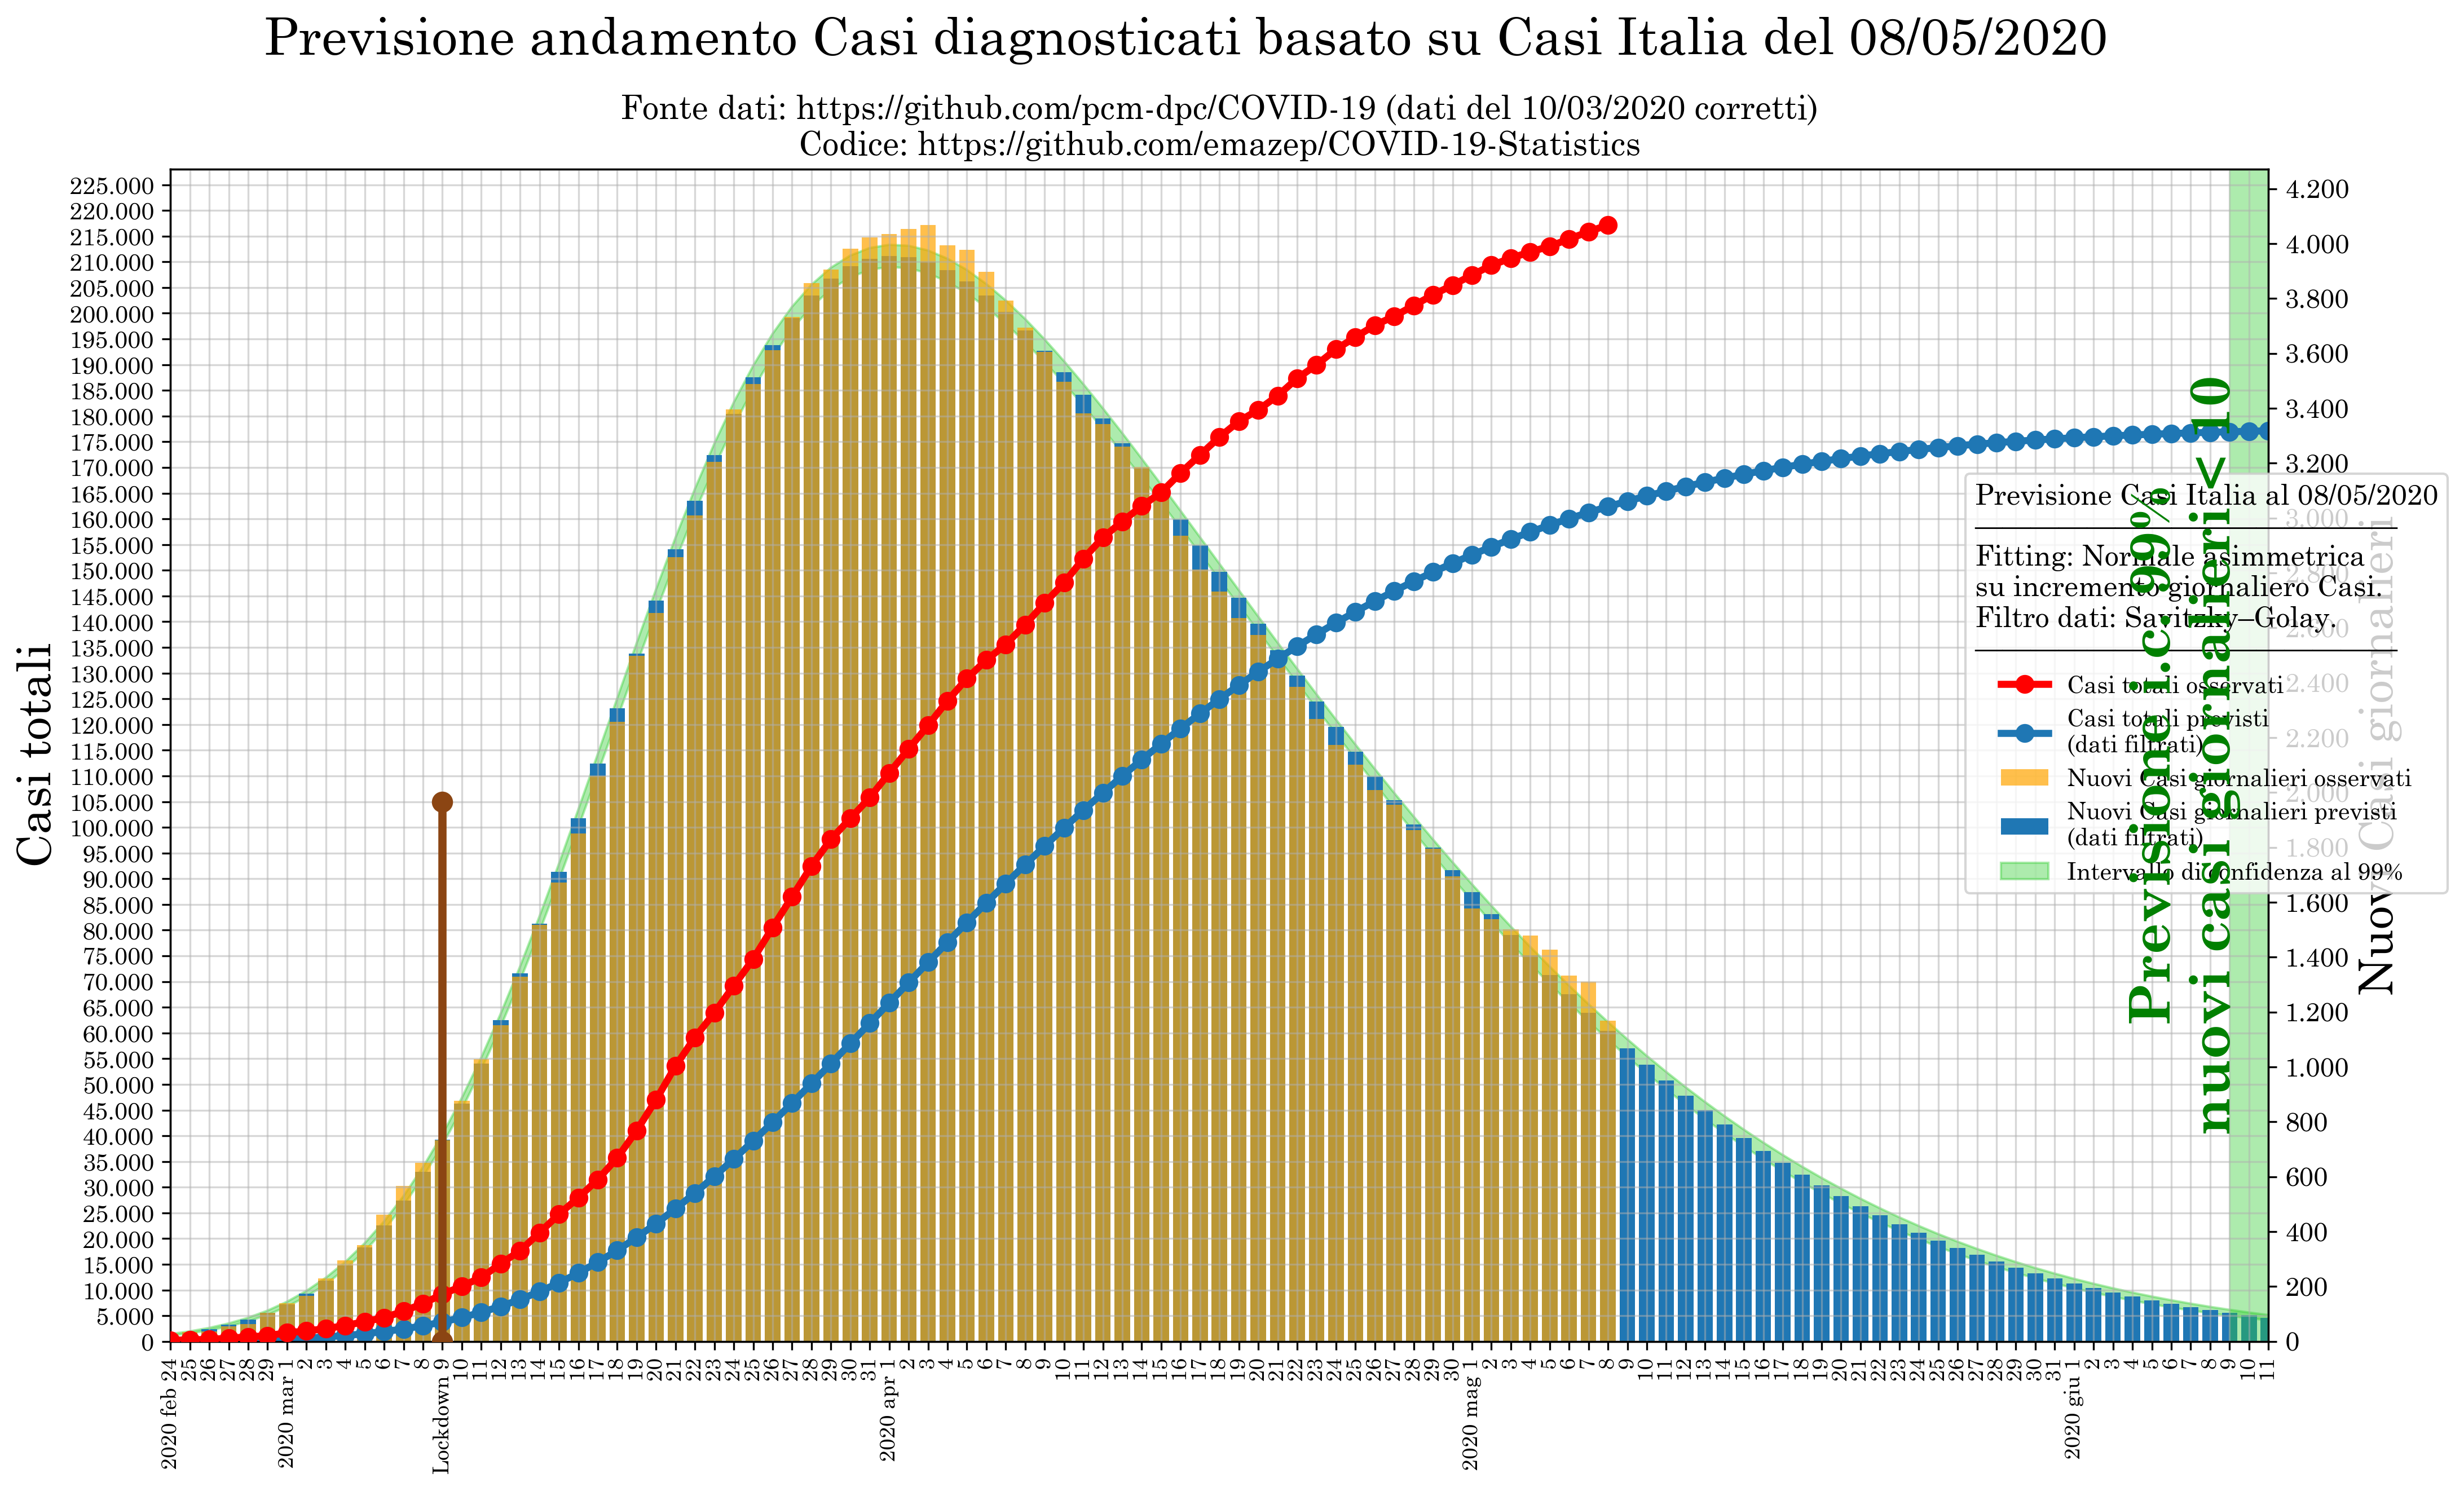

In [90]:
fig_cases = plot_cases(COLUMN)

In [91]:
min_index_10, avg_index_10, max_index_10 = limits(10)
min_index_100, avg_index_100, max_index_100 = limits(100)
min_index_1000, avg_index_1000, max_index_1000 = limits(1000)

print(list(numbers2dates([min_index_10, avg_index_10, max_index_10])))
print(list(numbers2dates([min_index_100, avg_index_100, max_index_100])))
print(list(numbers2dates([min_index_1000, avg_index_1000, max_index_1000])))
print()

BASE_DATE = date.fromisoformat('2020-02-24')
#current_date = ds_it.index.max()
current_date_number = df_it.index.max()
days_range_numbers = range(current_date_number-3, current_date_number+4)

for day_number in days_range_numbers:
    print('*** ' if day_number == current_date_number else '    ', end='')
    print(number2date(day_number), '\t', predicted_DELTA[day_number], '\t', dely_DELTA[day_number])

print(predicted_DELTA[5])

['30/06/2020', '02/07/2020', '03/07/2020']
['09/06/2020', '10/06/2020', '11/06/2020']
['10/05/2020', '11/05/2020', '11/05/2020']

    05/05/2020 	 1334.4819983289235 	 31.616541342195994
    06/05/2020 	 1264.6105822173568 	 31.89154901616525
    07/05/2020 	 1197.0602816566497 	 32.0827670693034
*** 08/05/2020 	 1131.8538598325958 	 32.18814272637391
    09/05/2020 	 1069.0052090863983 	 32.20713201153396
    10/05/2020 	 1008.519778495341 	 32.140458863988066
    11/05/2020 	 950.3950217437258 	 31.98990743045697
104.81139589300072


In [92]:
def plot_ICU():
    plt.rcParams.update(mpl.rcParamsDefault)
    set_plt_params()
    rcParams['font.size'] = 10
    #rcParams['axes.titlesize'] = 'x-large'

    max_date = ds_it.index.max()
    prediction_date_str = max_date.strftime('%d/%m/%Y')

    _, ax = plt.subplots(figsize=(16,8))
    ax.bar(
        df_it.index, df_it['terapia_intensiva'],
        label='Ricoveri in terapia\nintensiva osservati', color='orange', zorder=1, alpha=0.7
    )
    ax.bar(predicted_DELTA_index, predicted_DELTA, label='Ricoveri in terapia\nintensiva previsti', color='tab:blue', zorder=0)
    #ax.bar(df_it.index, df_it[column], label='Nuovi '+TITLE+' giornalieri osservati', color='orange', zorder=1)
    ax.fill_between(
        predicted_DELTA_index, predicted_DELTA-dely_DELTA, predicted_DELTA+dely_DELTA, color='limegreen', alpha=0.4, zorder=0,
        label='Intervallo di\nconfidenza al 99%'
    )

    special_x = {
        15: 'Lockdown',
        #62: 'Prediz. min.',
        #avg_index+1: 'Data più prob.'
    }

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format_dates_from_numbers(x, p, special=special_x, rotate=True)))
    ax.tick_params(axis='x', which='both', labelsize=8, rotation=90)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
    ax.tick_params(axis='y', which='both', labelsize=10, right=True, labelright=True)
    ax.set_ylabel('Ricoveri in terapia intensiva', fontsize=14)

    ax.grid(which='both', alpha=ALPHA)

    plt.axvline(x=14, linewidth=2, markersize=6, marker='o', zorder=4, color='darkviolet', ymax=0.4925)

    plt.axvspan(min_index_10, max_index_10, facecolor='violet', alpha=0.4, zorder=0)
    plt.axvspan(min_index_100, max_index_100, facecolor='red', alpha=0.4, zorder=0)
    plt.axvspan(min_index_1000, max_index_1000, facecolor='magenta', alpha=0.4, zorder=0)

    ax.text(
        avg_index_1000/max_index_10+0.001, 0.982, 'i.c. 99% ricoveri in t.i. < 1.000',
        horizontalalignment='center', verticalalignment='top', rotation='vertical',
        transform=ax.transAxes, fontsize=14, fontweight='bold', color='blue', zorder=10
    )
    ax.text(
        avg_index_100/max_index_10+0.002, 0.982, 'i.c. 99% ricoveri in t.i. < 100',
        horizontalalignment='center', verticalalignment='top', rotation='vertical',
        transform=ax.transAxes, fontsize=14, fontweight='bold', color='blue', zorder=10
    )
    ax.text(
        avg_index_10/max_index_10+0.002, 0.982, 'i.c. 99% ricoveri in t.i. < 10',
        horizontalalignment='center', verticalalignment='top', rotation='vertical',
        transform=ax.transAxes, fontsize=14, fontweight='bold', color='blue', zorder=10
    )

    ax.set_ylim(bottom=0)
    plt.xlim(left=0, right=max_index_10)
    #ax.set_xlabel('Giorni di lockdown', fontsize=20)

    ax.set_title(SUBTITLE_NO_CHN_NO_CORR, fontsize=14)
    plt.suptitle('    Previsione andamento ricoveri in terapia intensiva in Italia al ' + prediction_date_str, fontsize=22)

    handles, labels = ax.get_legend_handles_labels()
    handles.append(handles.pop(0))
    labels.append(labels.pop(0))
    sep = '\n——————————'
    ax.legend(
        handles, labels, title='Previsione ricoveri\nin terapia intensiva\nal ' + prediction_date_str + sep + '\nFitting: Skew normal.\nSmoothing: nessuno.' + sep,
        fontsize=10, loc='upper left' #bbox_to_anchor=(0.85, 0.75)
    )

    ax.set_zorder(1)
    #ax.patch.set_visible(False)

    fig = plt.gcf()
    plt.show()
    
    return fig

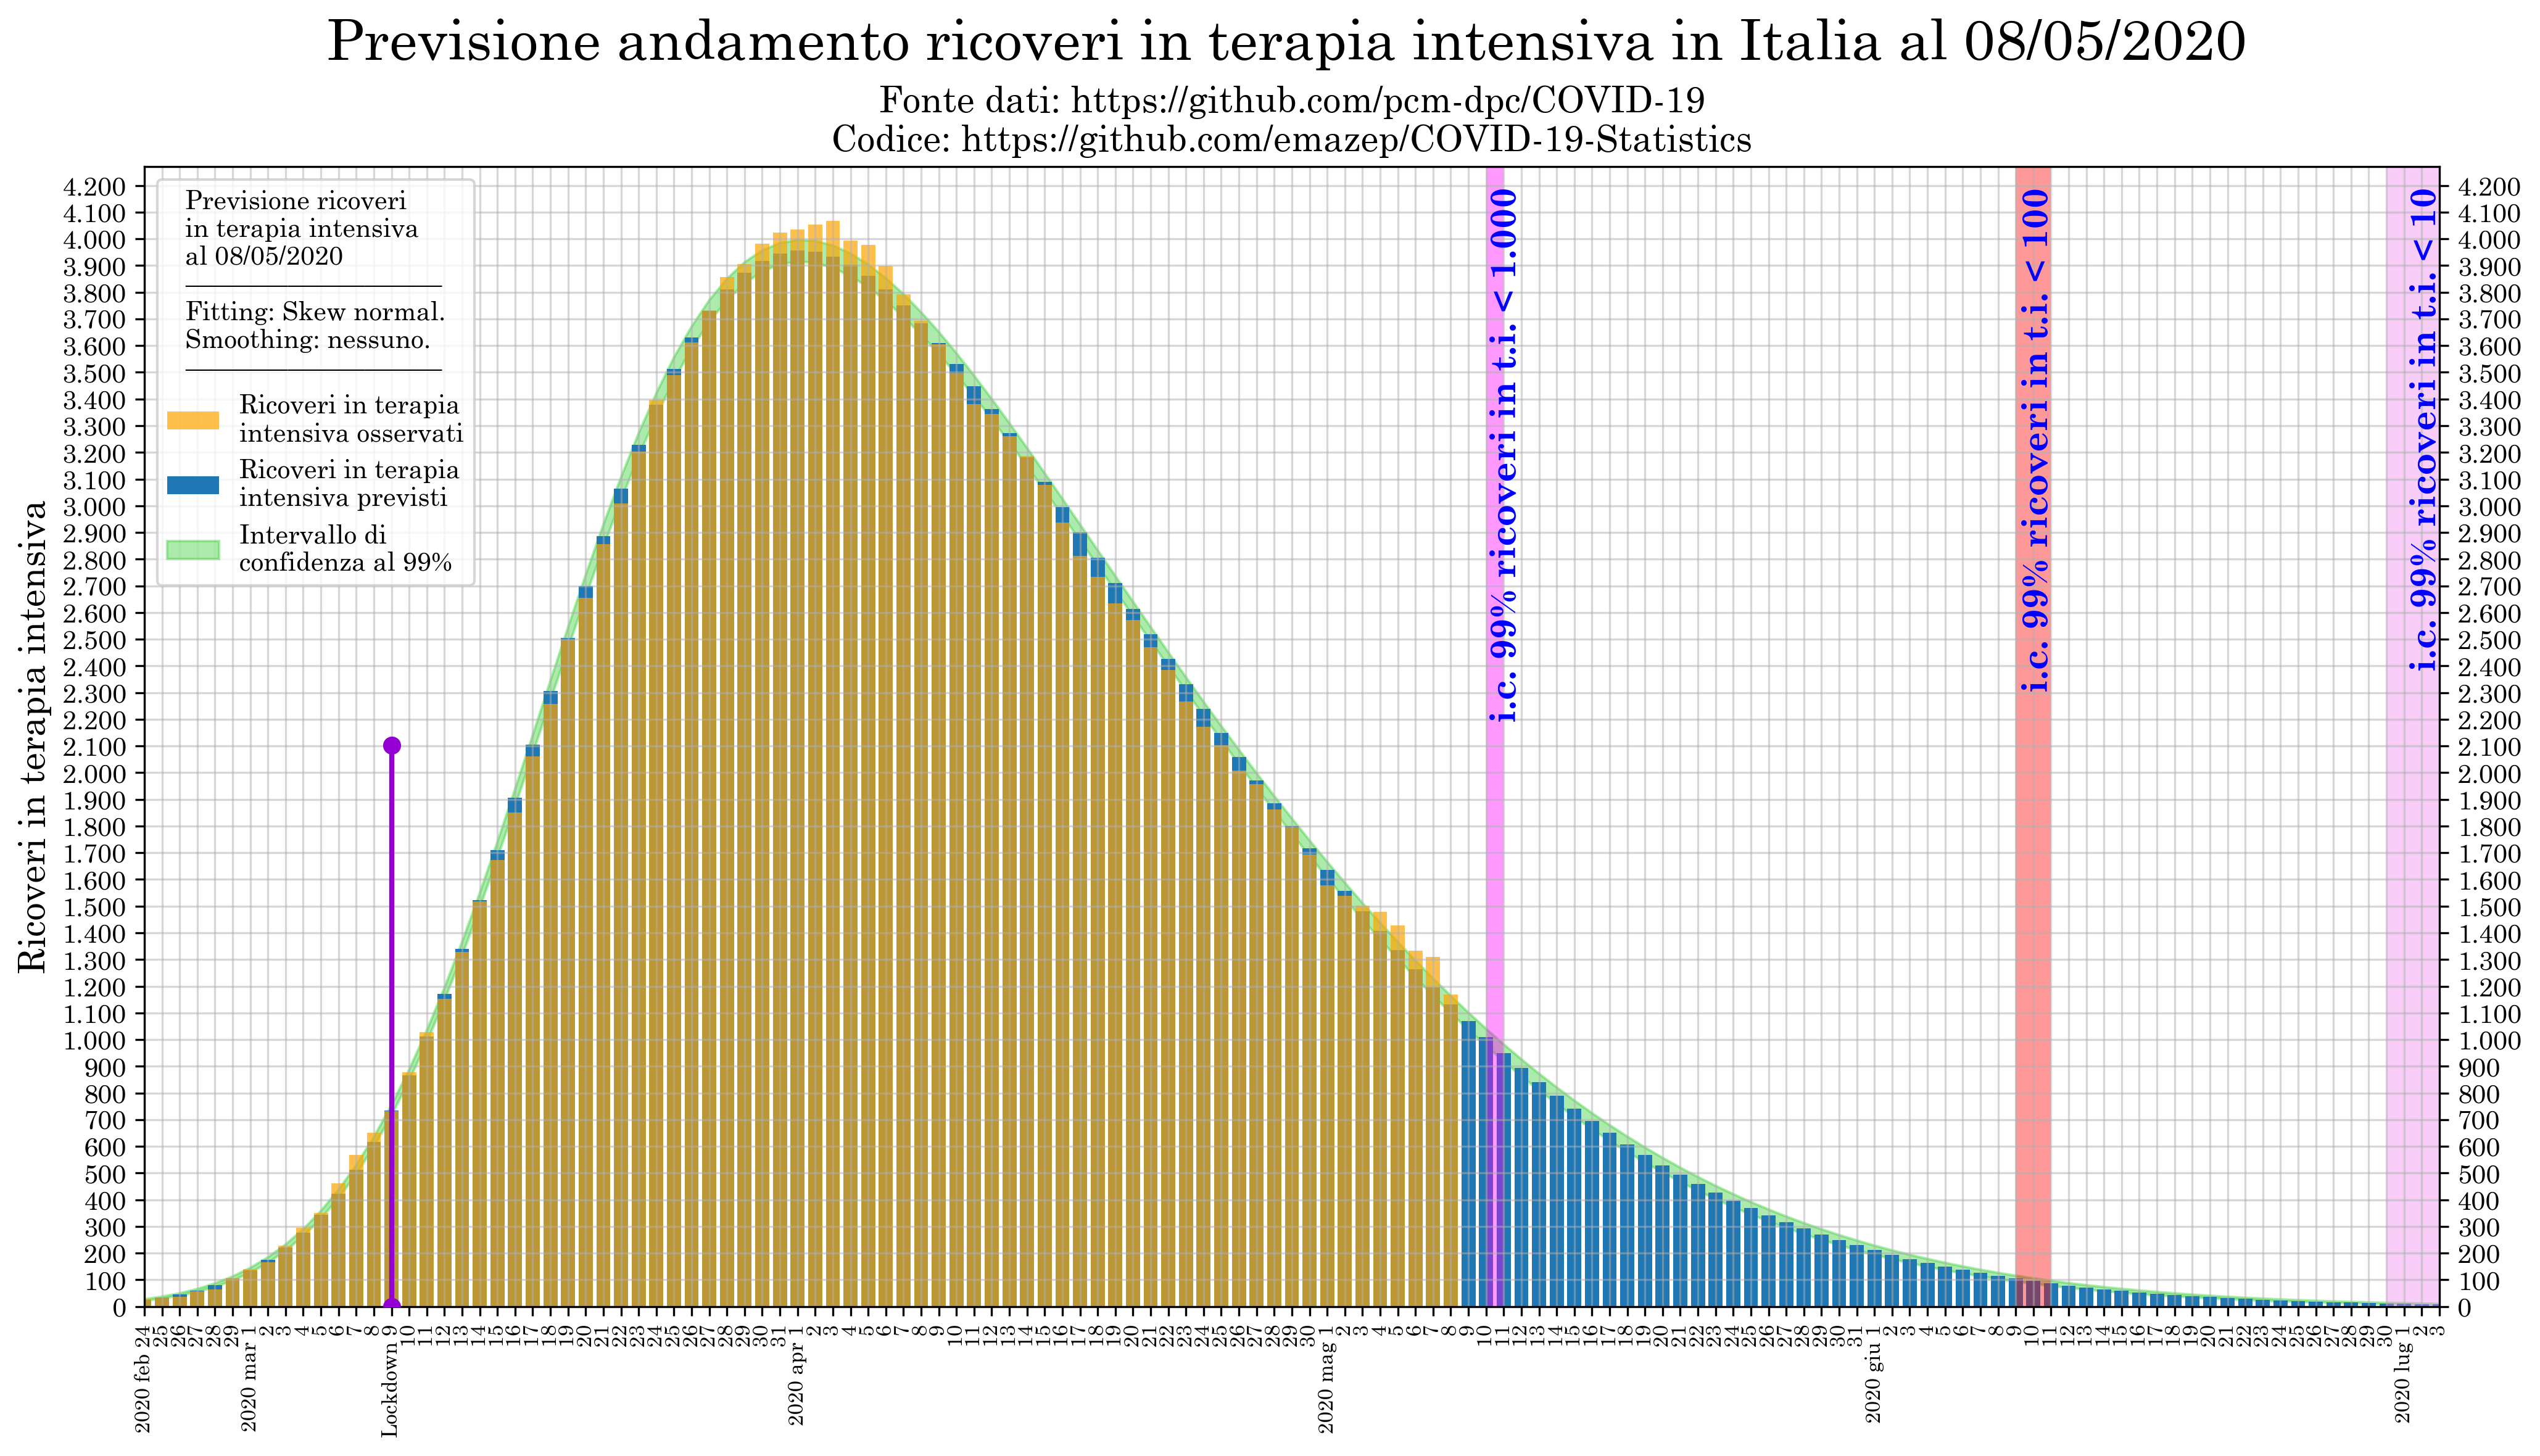

In [93]:
fig_ICU = plot_ICU()

In [74]:
with save_in_dir(OUTPUT_PATH):
    fig_cases.savefig('90_PRED_cases.png', transparent=False)

In [75]:
with save_in_dir(OUTPUT_PATH):
    fig_ICU.savefig('91_PRED_ICU.png', transparent=False)